# StochSS-Compute on AWS
Follow this tutorial to learn how to launch an AWS EC2 instance and run a simulation on it.

In [1]:
import sys, os
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../')))

from stochss_compute.cloud import EC2Cluster
from stochss_compute import RemoteSimulation

import gillespy2

### 1. Configuration
1. First, create an AWS account [here](https://aws.amazon.com/).
2. In order to make the AWS API calls to your account, you need an AWS access key and access key ID.  
From the IAM dashboard, click 'Manage access keys'.  
Then, under the Access keys tab, click 'Create New Access Key'.  
This file can only be downloaded once, but if something happens you can just make a new one.  
This file contains the Access Key ID and a Secret Access Key.
3. The simplest way to configure API calls is to download and install [AWS Command Line Interface](https://aws.amazon.com/cli/).  
Then, run `aws configure`.  
You will be asked for your AWS Access Key ID, your AWS Secret Access Key, and default region name (listed [here](https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/Concepts.RegionsAndAvailabilityZones.html#Concepts.RegionsAndAvailabilityZones.Regions)), such as `us-east-2`.  
If you prefer not to install this, you can set the environment variables `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, and `AWS_DEFAULT_REGION`.  
For a full list of environment variables you can set, see [here](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html#using-environment-variables).

In [2]:
# Uncomment the two lines below if using environment variables to configure AWS API calls. 
# from dotenv import load_dotenv # To install: python -m pip install python-dotenv
# load_dotenv() # Loads from a file named .env by default

### 2. Launch
- Instantiate a cluster object. 
- `stochss_compute.cloud` will first attempt to re-load an already running cluster by resource name, so you can continue where you left off.

In [3]:
cluster = EC2Cluster()

- Launch a StochSS-Compute instance, providing an AWS instance type.
- For more information about instance types, see [here](https://aws.amazon.com/ec2/instance-types/).
- Make sure you are aware of AWS pricing policies before proceeding. See [here](https://aws.amazon.com/ec2/pricing/) and [here](https://aws.amazon.com/ec2/pricing/on-demand/) for more information.

In [4]:
cluster.launch_single_node_instance('t2.micro')

2023-02-05 10:08:10,186 - EC2Cluster - INFO - Launching Network.......
2023-02-05 10:08:17,338 - EC2Cluster - INFO - Launching StochSS-Compute server instance. This might take a minute.......
2023-02-05 10:08:49,068 - EC2Cluster - INFO - Instance "i-03f371e113110fca4" is running.
2023-02-05 10:09:50,268 - EC2Cluster - INFO - Waiting on Docker daemon.
2023-02-05 10:10:50,930 - EC2Cluster - INFO - Waiting on Docker daemon.
2023-02-05 10:12:01,420 - EC2Cluster - INFO - Container "sssc" is running.
2023-02-05 10:12:01,422 - EC2Cluster - INFO - Restricting server access to only your ip.


[SourceIpRequest] http://3.141.170.216:29681/api/v2/cloud/sourceip


2023-02-05 10:12:02,623 - EC2Cluster - INFO - StochSS-Compute ready to go!


### 3. Run
- Create your model

In [5]:
def create_michaelis_menten(parameter_values=None):
    # Intialize the Model with a name of your choosing.
    model = gillespy2.Model(name="Michaelis_Menten")

    """
    Variables (GillesPy2.Species) can be anything that participates in or is produced by a reaction channel.

    - name: A user defined name for the species.
    - initial_value: A value/population count of species at start of simulation.
    """
    A = gillespy2.Species(name="A", initial_value=301)
    B = gillespy2.Species(name="B", initial_value=120)
    C = gillespy2.Species(name="C", initial_value=0)
    D = gillespy2.Species(name="D", initial_value=0)

    # Add the Variables to the Model.
    model.add_species([A, B, C, D])

    """
    Parameters are constant values relevant to the system, such as reaction kinetic rates.

    - name: A user defined name for reference.
    - expression: Some constant value.
    """
    rate1 = gillespy2.Parameter(name="rate1", expression=0.0017)
    rate2 = gillespy2.Parameter(name="rate2", expression=0.5)
    rate3 = gillespy2.Parameter(name="rate3", expression=0.1)

    # Add the Parameters to the Model.
    model.add_parameter([rate1, rate2, rate3])

    """
    Reactions are the reaction channels which cause the system to change over time.

    - name: A user defined name for the reaction.
    - reactants: A dictionary with participant reactants as keys, and consumed per reaction as value.
    - products: A dictionary with reaction products as keys, and number formed per reaction as value.
    - rate: A parameter rate constant to be applied to the propensity of this reaction firing.
    - propensity_function: Can be used instead of rate in order to declare a custom propensity function in string format.
    """
    r1 = gillespy2.Reaction(
            name="r1",
            reactants={'A': 1, 'B': 1}, 
            products={'C': 1},
            rate='rate1'
        )

    r2 = gillespy2.Reaction(
            name="r2",
            reactants={'C': 1}, 
            products={'A': 1, 'B': 1},
            rate='rate2'
        )

    r3 = gillespy2.Reaction(
            name="r3",
            reactants={'C': 1}, 
            products={'B': 1, 'D': 1},
            rate='rate3'
        )

    # Add the Reactions to the Model.
    model.add_reaction([r1, r2, r3])

    # Define the timespan of the model.
    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=100)
    
    # Set the timespan of the Model.
    model.timespan(tspan)
    return model

- Run it

In [6]:
model = create_michaelis_menten()

In [7]:
simulation = RemoteSimulation(model, server=cluster, solver=gillespy2.TauHybridSolver)

In [8]:
results = simulation.run()

[SimulationRunRequest] http://3.141.170.216:29681/api/v2/simulation/gillespy2/run


- Wait for/fetch results

Simulation is running. Downloading results when complete......
Results ready. Fetching.......


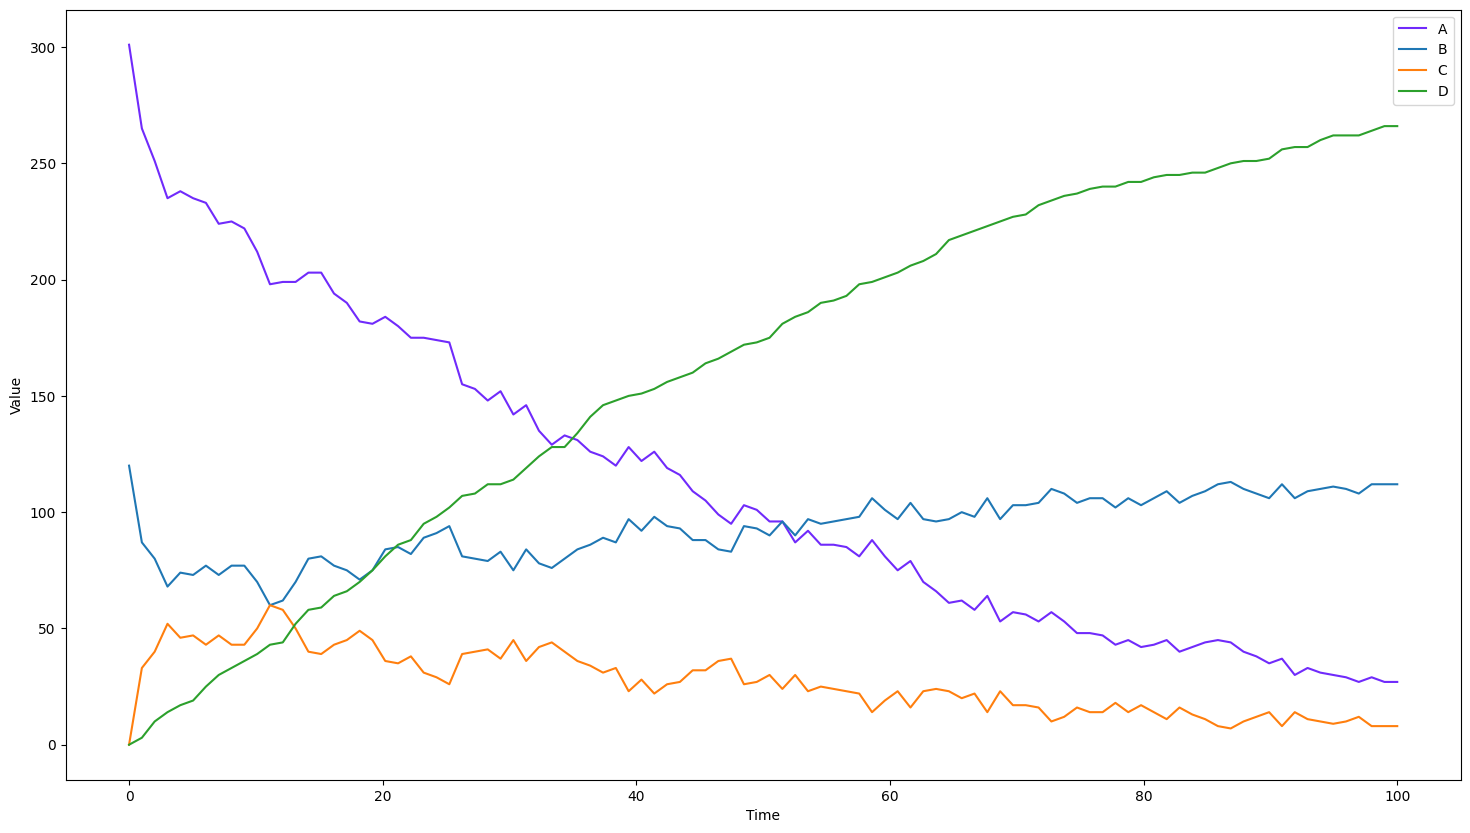

In [9]:
results.plot()

### 4. Clean Up
- Deletes all cluster resources that were created by `launch_single_node_instance()`.

In [10]:
cluster.clean_up()

2023-02-05 10:12:09,884 - EC2Cluster - INFO - Terminating "i-03f371e113110fca4". This might take a minute.......
2023-02-05 10:12:40,230 - EC2Cluster - INFO - Instance "i-03f371e113110fca4" terminated.
2023-02-05 10:12:40,507 - EC2Cluster - INFO - Deleting "sg-0608e8e81f54be123".......
2023-02-05 10:12:40,911 - EC2Cluster - INFO - Security group "sg-0608e8e81f54be123" deleted.
2023-02-05 10:12:41,226 - EC2Cluster - INFO - Deleting subnet-0abab130491d744d7.......
2023-02-05 10:12:41,629 - EC2Cluster - INFO - Subnet subnet-0abab130491d744d7 deleted.
2023-02-05 10:12:41,631 - EC2Cluster - INFO - Deleting subnet-0e0b9d06b97c0fe36.......
2023-02-05 10:12:42,041 - EC2Cluster - INFO - Subnet subnet-0e0b9d06b97c0fe36 deleted.
2023-02-05 10:12:42,141 - EC2Cluster - INFO - Detaching igw-0c2f77d6fc9a1554c.......
2023-02-05 10:12:42,453 - EC2Cluster - INFO - Gateway igw-0c2f77d6fc9a1554c detached.
2023-02-05 10:12:42,454 - EC2Cluster - INFO - Deleting igw-0c2f77d6fc9a1554c.......
2023-02-05 10:12: